# 2D FEM SOLVER : ALLEN-CAHN EQUATION

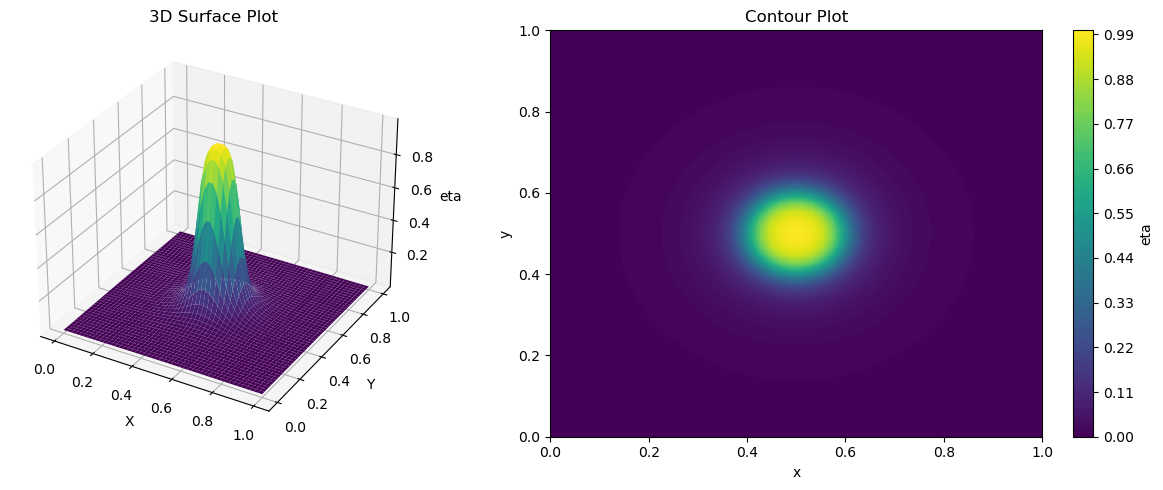

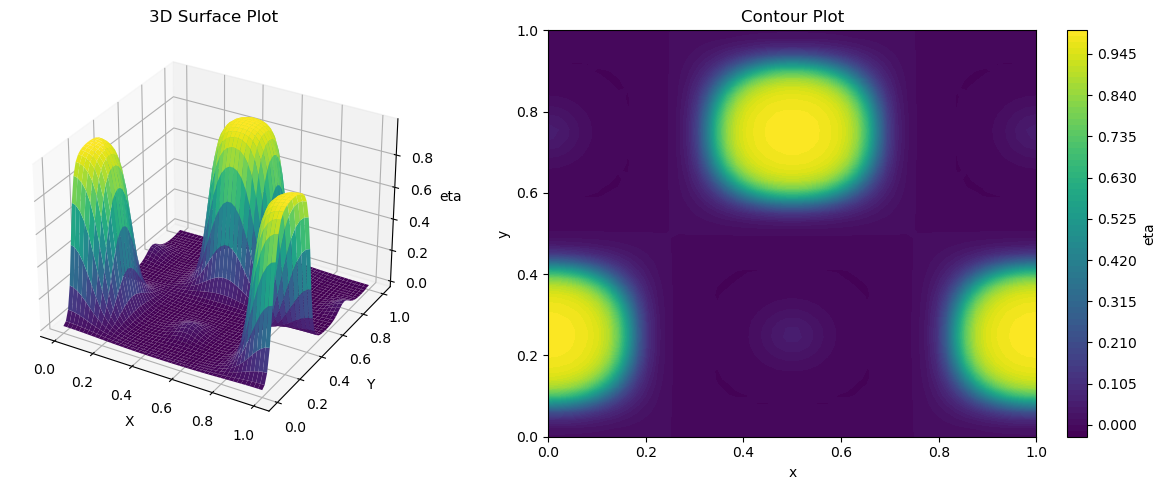

In [5]:
import numpy as np
import sympy as sym
import scipy
from scipy.interpolate import PPoly, splrep
from scipy.special import roots_legendre
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#Double Well potential and derivative
t = sym.var('t')
f = t**2 * (t - 1)**2
F = f.diff(t, 1)
F = sym.lambdify(t,F, 'numpy')

def one_dim_M_K(x, ndofs,deg):
    
    #Basis Function and derivative
    basisfun = [PPoly.from_spline(splrep(x, np.eye(ndofs)[i], k=deg)) for i in range(ndofs)]
    dbasisfun = [basisfun[i].derivative(1) for i in range(len(basisfun))]
    
    m = len(basisfun)
    bp = np.unique(basisfun[0].x) #Breakpoints
    bpd = np.diff(bp)
    
    #Quadrature points and weights
    q, w = roots_legendre(deg)
    q = (q + 1.0) / 2.0
    w = w / 2.0           
    
    Q = np.array([bp[i] + bpd[i] * q for i in range(len(bpd))]).reshape((-1,))
    W = np.array([w * bpd[i] for i in range(len(bpd))]).reshape((-1,))

    Basisquad = np.array([basisfun[i](Q) for i in range(m)]).T
    dBasisquad = np.array([dbasisfun[i](Q) for i in range(m)]).T
    
    #One Dimensional Mass matrix and Stiffness Matrix
    M = np.array([[np.dot(Basisquad[:, i] * W, Basisquad[:, j]) for j in range(m)] for i in range(m)])
    K = np.array([[np.dot(dBasisquad[:, i] * W, dBasisquad[:, j]) for j in range(m)] for i in range(m)])
    
    return M,K,basisfun

def two_dim_tensor_M_K(M,K,ndofs):
    
    assert M.shape[0] == K.shape[0], f"Shape Mismatch between M anb K"
    
    #Two Dimensional Mass matrix and Stiffness Matrix based on tensor product structure
    M_2d = np.einsum('ik,jl->ijkl', M, M).reshape(ndofs**2, ndofs**2)
    K_2d = np.einsum('ik,jl->ijkl', K, M).reshape((ndofs**2, ndofs**2)) + np.einsum('ik,jl->ijkl', M, K).reshape((ndofs**2, ndofs**2))
                    
    return M_2d, K_2d

def solver(func0, eps, dt, ndofs, deg):
    x = np.linspace(0, 1, ndofs)
    y = np.linspace(0, 1, ndofs)
    tstps = int(1 / dt) + 1

    M, K,basisfun = one_dim_M_K(x, ndofs, deg)
    M_2d, K_2d = two_dim_tensor_M_K(M, K, ndofs)

    eta_2d = np.zeros((tstps, ndofs**2))
    for i in range(tstps):
        if i == 0:
            eta_2d[i] = func0(x[:, None], y[None, :]).reshape(-1)
        else:
            A_2d = M_2d + dt * eps ** 2 * K_2d
            b_2d = M_2d.dot(eta_2d[i - 1] - dt * F(eta_2d[i - 1].reshape((ndofs, ndofs))).flatten())
            eta_2d[i] = scipy.linalg.solve(A_2d, b_2d)

    return eta_2d,basisfun

def plot_2d(eta_2d, dt, ndofs):
    x = np.linspace(0, 1, ndofs)
    y = np.linspace(0, 1, ndofs)
    tstps = int(1 / dt) + 1

    X, Y = np.meshgrid(x, y)

    # 3D surface plot
    eta_2d_grid = eta_2d.reshape((tstps, ndofs, ndofs))
    fig = plt.figure(figsize=(13, 5))
    ax = fig.add_subplot(121, projection='3d')
    ax.plot_surface(X, Y, eta_2d_grid[-1], cmap='viridis', linewidth=0.5, antialiased=True)
    ax.set(xlabel='X', ylabel='Y', zlabel='eta', title='3D Surface Plot')

    # Contour plot
    eta_2d_contour = eta_2d[-1].reshape((ndofs, ndofs))
    ax = fig.add_subplot(122)
    contour = ax.contourf(X, Y, eta_2d_contour, levels=100, cmap='viridis')
    fig.colorbar(contour, ax=ax, label='eta')
    ax.set(xlabel='x', ylabel='y', title='Contour Plot')
 

    plt.tight_layout()
    plt.show()
    
if __name__ == '__main__':
    
    eps = 0.01
    dt = 0.1 
    ndofs = 50
    deg = 2
    
    #Initial eta
    funcs = [
             lambda x, y: 1 / (1 + 100 * ((x - 0.5) ** 2 + (y - 0.5) ** 2)),  #Runge Function 2D
             lambda x, y: np.sin(2 * np.pi * x) * np.cos(2 * np.pi * y)       #sincos Function 2D
            ]
    
    for func0 in funcs:
        eta_2d,basisfun = solver(func0, eps, dt, ndofs, deg)
        plot_2d(eta_2d, dt, ndofs)